# Book Recommender


## Project Details

The goal of this project is to develop a book recommendation system that suggests titles to users based on similarities in genre and user ratings. We'll leverage unsupervised learning techniques to uncover latent patterns in the data that can drive effective recommendations.

The dataset we'll be using comes from Kaggle: [Goodreads Books with Genres](https://www.kaggle.com/datasets/middlelight/goodreadsbookswithgenres). It consists of 11,127 entries sourced from the Goodreads API, including key attributes such as **title**, **author**, **average\_rating**, and **genre**.

Our approach is to leverage genre and rating data, using techniques such as **TruncatedSVD** and **item-item similarity**. The goal is to input a given book and return a curated list of similar titles based on these characteristics.



In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.sparse import csr_matrix
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor


## Exploratory Data Analysis

#### Inspect the data

In [2]:
data_path = 'Goodreads_books_with_genres.csv'
df = pd.read_csv(data_path)

In [3]:
df.head()

,Book Id,Title,Author,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher,genres
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,0439785960,9780439785969,eng,652,2095690,27591,9/16/2006,Scholastic Inc.,"Fantasy;Young Adult;Fiction;Fantasy,Magic;Chil..."
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,0439358078,9780439358071,eng,870,2153167,29221,9/1/2004,Scholastic Inc.,"Fantasy;Young Adult;Fiction;Fantasy,Magic;Chil..."
2,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9780439554893,eng,352,6333,244,11/1/2003,Scholastic,"Fantasy;Fiction;Young Adult;Fantasy,Magic;Chil..."
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,043965548X,9780439655484,eng,435,2339585,36325,5/1/2004,Scholastic Inc.,"Fantasy;Fiction;Young Adult;Fantasy,Magic;Chil..."
4,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78,0439682584,9780439682589,eng,2690,41428,164,9/13/2004,Scholastic,"Fantasy;Young Adult;Fiction;Fantasy,Magic;Adve..."


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11127 entries, 0 to 11126
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Book Id             11127 non-null  int64  
 1   Title               11127 non-null  object 
 2   Author              11127 non-null  object 
 3   average_rating      11127 non-null  float64
 4   isbn                11127 non-null  object 
 5   isbn13              11127 non-null  int64  
 6   language_code       11127 non-null  object 
 7   num_pages           11127 non-null  int64  
 8   ratings_count       11127 non-null  int64  
 9   text_reviews_count  11127 non-null  int64  
 10  publication_date    11127 non-null  object 
 11  publisher           11127 non-null  object 
 12  genres              11030 non-null  object 
dtypes: float64(1), int64(5), object(7)
memory usage: 1.1+ MB


So we can see that there are 11127 rows and 13 features in the data frame

#### Data Cleaning  
First, we need to remove na values

In [5]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11030 entries, 0 to 11126
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Book Id             11030 non-null  int64  
 1   Title               11030 non-null  object 
 2   Author              11030 non-null  object 
 3   average_rating      11030 non-null  float64
 4   isbn                11030 non-null  object 
 5   isbn13              11030 non-null  int64  
 6   language_code       11030 non-null  object 
 7   num_pages           11030 non-null  int64  
 8   ratings_count       11030 non-null  int64  
 9   text_reviews_count  11030 non-null  int64  
 10  publication_date    11030 non-null  object 
 11  publisher           11030 non-null  object 
 12  genres              11030 non-null  object 
dtypes: float64(1), int64(5), object(7)
memory usage: 1.2+ MB


Genre is a valuable feature. Let’s examine 10 sample cases.

In [6]:
with pd.option_context('display.max_colwidth', None):
    print(df['genres'].sample(10))

4283                                                                                     Fiction;Novels;Literature,American;Literary Fiction;The United States Of America
7212                                                   Fiction;Book Club;Contemporary;Literary Fiction;Adult Fiction;Cultural,Scotland;Novels;Literature;Family;Audiobook
4671     Sequential Art,Graphic Novels;Sequential Art,Comics;Fantasy;Fiction;Graphic Novels Comics;Comics,Comic Book;Fantasy,Urban Fantasy;Horror;Fantasy,Mythology;Death
6610                                  Young Adult;Science Fiction;Fiction;Horror;Science Fiction,Dystopia;Young Adult,Teen;Fantasy;Thriller;Childrens;Speculative Fiction
152                                             Science Fiction;Fiction;Classics;Science Fiction Fantasy;Fantasy;Novels;Speculative Fiction;Philosophy;Audiobook;Religion
7269                                                                                                                          Fantasy;Fiction;Science 

Looks like the genre uses both semicolons and commas. If we only split by semicolon, we’d end up with odd combinations like "Young Adult,Young Adult Science Fiction" as one genre, which doesn’t make sense. We’ll need to split further.

In [7]:
df['genre_list'] = (
    df['genres']
      .str.replace(';', ',')
      .str.split(',')
      .apply(lambda x: list(set(g.strip().lower() for g in x if g.strip())))
)

mlb = MultiLabelBinarizer()
genre_dummies = pd.DataFrame(
    mlb.fit_transform(df['genre_list']),
    columns=mlb.classes_,
    index=df.index
)
genre_dummies.count()

12th century    11030
13th century    11030
14th century    11030
15th century    11030
16th century    11030
                ...  
yuri            11030
zambia          11030
zen             11030
zimbabwe        11030
zombies         11030
Length: 893, dtype: int64

#### Reducing Genre Cardinality
There are 893 distinct genres, so it's important to reduce the cardinality for better modeling.

In [8]:
genre_counts = genre_dummies.sum()

bins = [0, 1, 5, 10, 25, 50, 100, 500, 1000, genre_counts.max()]
labels = ['(0, 1]', '(1, 5]', '(5, 10]', '(10, 25]', '(25, 50]', '(50, 100]', '(100, 500]', '(500, 1000]', f'(1000, {int(genre_counts.max())}]']

binned = pd.cut(genre_counts, bins=bins, labels=labels, right=True, include_lowest=False)

bin_counts = binned.value_counts().sort_index()

print(bin_counts)

(0, 1]          140
(1, 5]          190
(5, 10]          97
(10, 25]        129
(25, 50]         88
(50, 100]        77
(100, 500]      120
(500, 1000]      26
(1000, 6934]     26
Name: count, dtype: int64


A cutoff of 100 is selected since it accounts for under 1% of the dataset.



In [9]:
min_count = 100
filtered_genre_dummies = genre_dummies[genre_counts[genre_counts >= min_count].index]

#### Data Transform 
Here we can transform the genre column into binary features

In [10]:
encoded_df = pd.concat([df.drop('genres', axis=1), filtered_genre_dummies], axis=1)
encoded_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11030 entries, 0 to 11126
Columns: 187 entries, Book Id to young adult
dtypes: float64(1), int64(179), object(7)
memory usage: 15.8+ MB


Verify that the binary feature is functioning correctly.

*Note: "Historical mystery" is missing due to its low frequency.*

In [11]:
genres_for_row = encoded_df.columns[encoded_df.iloc[5812] == 1].tolist()
print(genres_for_row)
print(sorted(encoded_df.iloc[5812]['genre_list']))

['audiobook', 'crime', 'fiction', 'historical', 'historical fiction', 'mystery', 'thriller', 'war']
['audiobook', 'crime', 'fiction', 'historical', 'historical fiction', 'historical mystery', 'mystery', 'thriller', 'war']


#### Numerical Features Analysis
This plot displays histograms for key numerical columns to reveal their value distributions, helping identify patterns, skewness, and outliers.

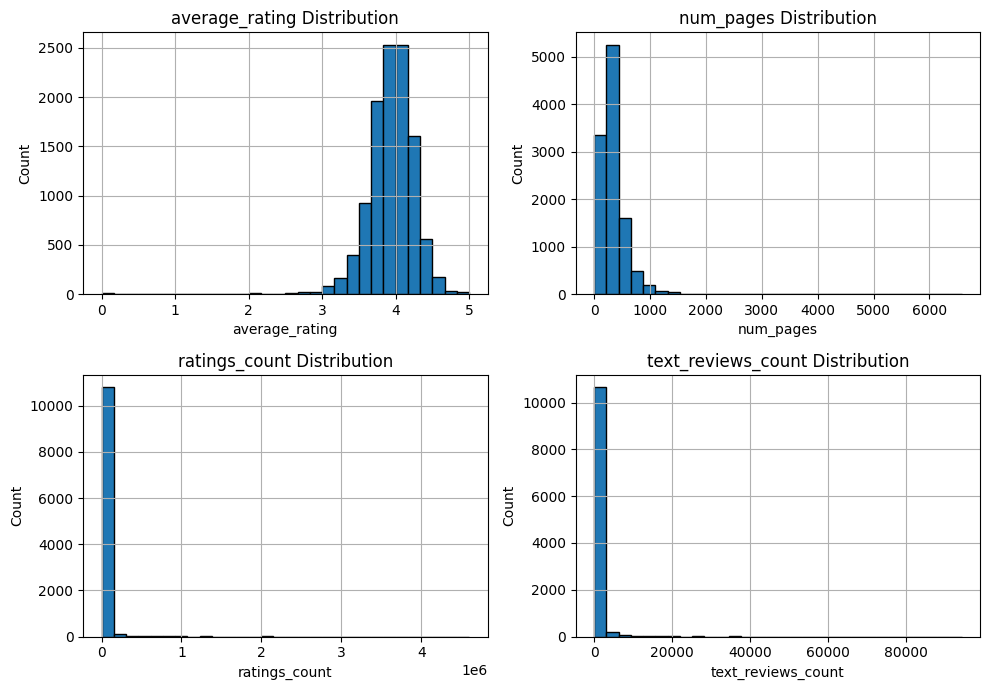

In [12]:
numerical_features = ['average_rating', 'num_pages', 'ratings_count', 'text_reviews_count']


fig, axes = plt.subplots(2, 2, figsize=(10, 7))
for ax, col in zip(axes.flatten(), numerical_features):
    df[col].hist(bins=30, edgecolor='black', ax=ax)
    ax.set_title(f'{col} Distribution')
    ax.set_xlabel(col)
    ax.set_ylabel('Count')
plt.tight_layout()
plt.show()

#### Examine Relationships Between Numerical Variables
The scatter plot matrix below highlights several key patterns:
* average_rating shows a positive relationship with both ratings_count and text_reviews_count.
* num_pages also correlates positively with ratings_count and text_reviews_count, though less strongly.
* A strong positive correlation exists between ratings_count and text_reviews_count.

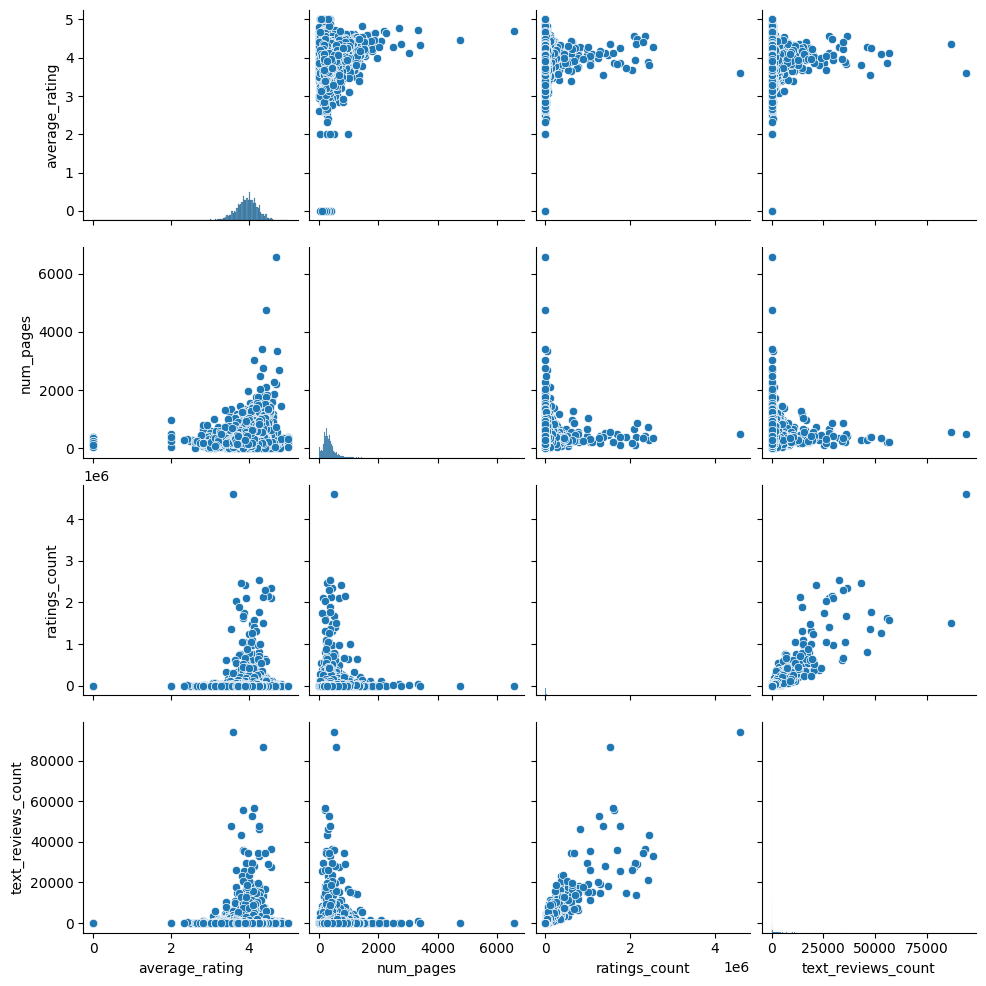

In [13]:
sns.pairplot(df[numerical_features])
plt.show()

#### Dropping Unnecessary Features
These features aren't useful for our recommender, because they're irrelevant and not meaningful

In [14]:
features = encoded_df.drop(['Book Id', 'Title', 'Author', 'isbn', 'isbn13', 'language_code', 'publication_date', 'publisher', 'genre_list'], axis=1)


## Model Building
We'll begin with TruncatedSVD and Cosine Similarity, followed by comparisons with other models.

### Data Preprocessing
Apply Feature Normalization

In [15]:
standard_scaler = StandardScaler()
normalized_features = standard_scaler.fit_transform(features)

sparse matrix creation for SVC model

In [16]:
features_sparse = csr_matrix(normalized_features)

### Hyperparameter Tuning

In optimizing the TruncatedSVD model, we will tune the n_components parameter to strike a balance between model accuracy (explained variance ratio) and overfitting

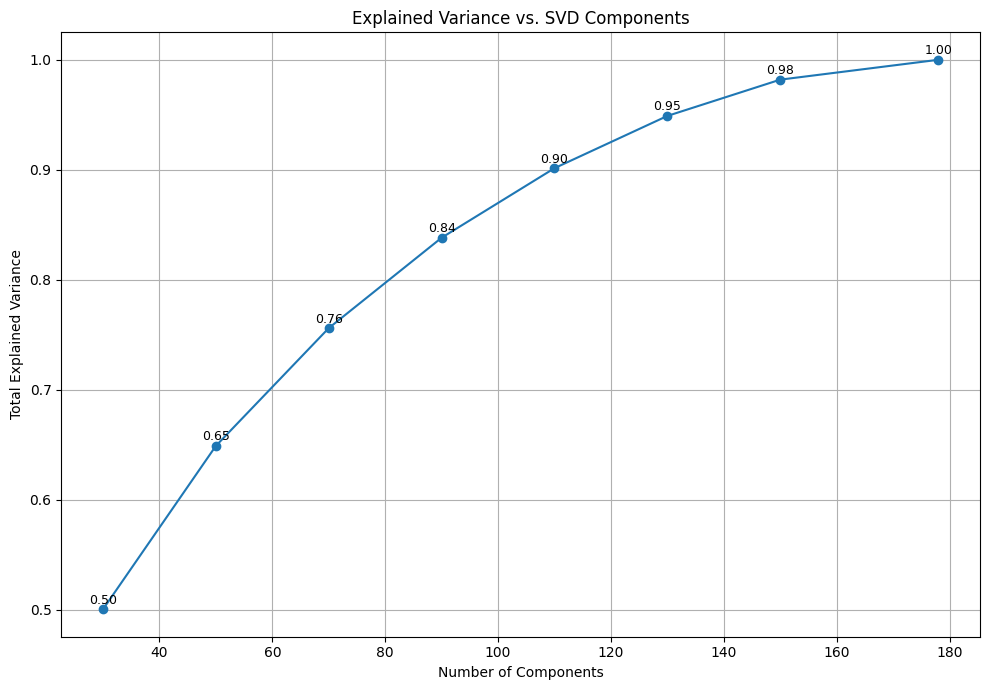

In [17]:
n_components_list = [30, 50, 70, 90, 110, 130, 150, 178]

variance_scores = []
best_n, best_score = 0, 0

for n in n_components_list:
    model = TruncatedSVD(n_components=n, random_state=42)
    model.fit(features_sparse)
    score = model.explained_variance_ratio_.sum()

    variance_scores.append(score)

    if score > best_score:
        best_score = score
        best_n = n

plt.figure(figsize=(10, 7))
plt.plot(n_components_list, variance_scores, marker='o')
for x, y in zip(n_components_list, variance_scores):
    plt.text(x, y + 0.005, f'{y:.2f}', ha='center', fontsize=9)
plt.title('Explained Variance vs. SVD Components')
plt.xlabel('Number of Components')
plt.ylabel('Total Explained Variance')
plt.grid(True)
plt.tight_layout()
plt.show()


We can see that an n_components value of 130 yields a reasonable explained variance of 95%. Increasing the number of components beyond this point leads to diminishing returns, while also increasing the risk of overfitting or adding unnecessary complexity.

In [18]:
best_n_component = 130

We can fit and transform with TruncatedSVD to reduce the dimensionality.

In [19]:
svd = TruncatedSVD(n_components=best_n_component, random_state=42)
features_reduced = svd.fit_transform(features_sparse)

Inverse transform the reduced features to approximate the original data. Based on R square score, we can see that the reduced feature preserved most of the original data

In [20]:
reconstructed_features = svd.inverse_transform(features_reduced)
original_features = features_sparse.toarray()

r2 = r2_score(original_features, reconstructed_features)
print(f'R-squared value: {r2}')

R-squared value: 0.9489766403661908


#### Item-Item Similarity

With feature reduced, we can recommend books based based on consine similarity without worrying about sparse dimension issue

In [21]:
similarity_matrix = cosine_similarity(features_reduced)

In [22]:
def recommend_books(book_id, num_recommendations=5):
    book_index = encoded_df.index[encoded_df['Book Id'] == book_id][0]
    
    # Get similarity scores for the given book
    similarity_scores = similarity_matrix[book_index]
    
    # Get indices of the most similar books (excluding the book itself)
    similar_indices = similarity_scores.argsort()[-(num_recommendations + 1):-1][::-1]
    
    return similar_indices

target_index = 50
target_book_id = encoded_df['Book Id'].iloc[target_index]
recommended_indices = recommend_books(target_book_id, num_recommendations=5)

# Print the recommendations
print("\n" + "="*40)
print(f"Recommendations Based on: '{encoded_df['Title'].iloc[target_index]}'")
print("="*40)
for idx in recommended_indices:
    print(f"→ {encoded_df['Title'].iloc[idx]}")
print("="*40 + "\n")


Recommendations Based on: 'Giving Good Weight'
→ Galapagos: A Natural History
→ Topsail Island: Mayberry by the Sea
→ Arctic Dreams
→ Basin and Range
→ Assembling California



### Evaluation

Measure the average similarity between items in the recommendation list

In [23]:
ils = np.mean([
    similarity_matrix[i, j]
    for idx, i in enumerate(recommended_indices)
    for j in recommended_indices[idx + 1:]
])

print(f"Similarity for the recommended book: {ils}")

Similarity for the recommended book: 0.8873180919485557


The result is 88% similarity, which means it's a good recommendation


### Supervised Models

We can apply supervised learning models—such as Linear Regression, Random Forest, and Gradient Boosting—to predict book ratings. This approach is valuable in recommendation systems, as accurate rating predictions allow us to suggest books that are likely to interest users. While this project doesn't include user-specific data, we use predicted ratings as a proxy for personalized scores.

In [24]:
target = df['average_rating']

In [25]:
supervised_genre_dummies = genre_dummies[genre_counts[genre_counts >= 130].index]
supervised_encoded_df = pd.concat([df.drop('genres', axis=1), supervised_genre_dummies], axis=1)
supervised_features = supervised_encoded_df.drop(['Book Id', 'Title', 'Author', 'isbn', 'isbn13', 'language_code', 'publication_date', 'publisher', 'genre_list', 'average_rating'], axis=1)
supervised_normalized_features = standard_scaler.fit_transform(supervised_features)

X_train, X_test, y_train, y_test = train_test_split(supervised_normalized_features, target, test_size=0.2, random_state=42)

#### Linear Regression

In [26]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
y_pred_lr = model_lr.predict(X_test)
r2_lr = r2_score(y_test, y_pred_lr)
mse_lr = mean_squared_error(y_test, y_pred_lr)

print(f'Linear Regression - Mean Squared Error: {mse_lr}')
print(f'Linear Regression - R-squared: {r2_lr}')

Linear Regression - Mean Squared Error: 0.081442407106726
Linear Regression - R-squared: 0.19998751670410853


#### Random Forest

In [27]:
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)
y_pred_rf = model_rf.predict(X_test)
r2_rf = r2_score(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_lr)

print(f'Random Forest - Mean Squared Error: {mse_rf}')
print(f'Random Forest - R-squared: {r2_rf}')

Random Forest - Mean Squared Error: 0.081442407106726
Random Forest - R-squared: 0.2328512378011215


#### Gradient Boosting

In [28]:
model_gb = GradientBoostingRegressor(n_estimators=100, random_state=42)
model_gb.fit(X_train, y_train)
y_pred_gb = model_gb.predict(X_test)
r2_gb = r2_score(y_test, y_pred_gb)
mse_gb = mean_squared_error(y_test, y_pred_gb)

print(f'Gradient Boosting - Mean Squared Error: {mse_gb}')
print(f'Gradient Boosting - R-squared: {r2_gb}')

Gradient Boosting - Mean Squared Error: 0.0817882597697199
Gradient Boosting - R-squared: 0.19659019020547408


And the predicted rating is quite close to target

In [29]:
input_features = supervised_normalized_features
predicted_ratings = model_lr.predict(input_features)
encoded_df['PredictedRating_LR'] = predicted_ratings

print(f"{encoded_df['Title'].iloc[50]} has predicted rating of {predicted_ratings[50]} and actual rating of {encoded_df['average_rating'].iloc[50]}")


Giving Good Weight has predicted rating of 3.9434482682275487 and actual rating of 4.23


In [30]:
input_features = supervised_normalized_features
predicted_ratings = model_rf.predict(input_features)
encoded_df['PredictedRating_RF'] = predicted_ratings

print(f"{encoded_df['Title'].iloc[50]} has predicted rating of {predicted_ratings[50]} and actual rating of {encoded_df['average_rating'].iloc[50]}")


Giving Good Weight has predicted rating of 3.8491999999999997 and actual rating of 4.23


In [31]:
input_features = supervised_normalized_features
predicted_ratings = model_gb.predict(input_features)
encoded_df['PredictedRating_GB'] = predicted_ratings


print(f"{encoded_df['Title'].iloc[50]} has predicted rating of {predicted_ratings[50]} and actual rating of {encoded_df['average_rating'].iloc[50]}")


Giving Good Weight has predicted rating of 3.9150767266469657 and actual rating of 4.23


## Conclusion
TruncatedSVD proved to be an effective method for dimensionality reduction, significantly simplifying the feature space while preserving enough structure to support high-quality book recommendations. Its ability to compress sparse genre data into lower-dimensional vectors made similarity-based recommendations both efficient and performant.

While we also explored supervised learning models—such as Logistic Regression, Random Forest, and Gradient Boosting—their contribution to recommendation quality was limited in this context. Despite achieving low mean squared error (MSE ≈ 0.08), these models did not offer a clear advantage for generating recommendations, primarily because we lacked user-level interaction data to support personalized predictions.

A major limitation of this project was the absence of ground truth data for evaluating recommendation quality. Without real user feedback or curated similarity labels, it was challenging to assess the relevance of the model's outputs. If such ground truth data were available, we could have conducted more robust evaluation using metrics like precision@k, recall@k, or mean reciprocal rank (MRR).

Overall, the project demonstrated that even without user data, content-based methods—especially dimensionality-reduced similarity models—can provide meaningful recommendations. However, integrating user behavior or preference data in future work would open the door to more personalized, accurate, and evaluable recommendation systems.